In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from scipy import stats
import numpy.ma as ma
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import seaborn as sns
# %matplotlib inline

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [26]:
## Possible choices for cEOF k-means - a) DJF b) MAM c) DJF-MAM
djf_dict = {'start_date': '1979-12-01',
             'end_date': '2018-02-28',
             'mon_s': 12,
             'mon_e': 2,
             'ys': 1979,
             'ye': 2018,
             'day_s': '01',
             'day_e': '28',
             'ssn': 'djf'}

# Option 2 - MAM only
mam_dict = {'start_date': '1979-03-01',
             'end_date': '2018-5-31',
             'mon_s': 3,
             'mon_e': 5,
             'ys': 1979,
             'ye': 2018,
             'day_s': '01',
             'day_e': '31',
             'ssn': 'mam'}

# Option 3 - DJF and MAM combined
djfmam_dict = {'start_date': '1979-03-01',
               'end_date': '2018-5-31',
               'mon_s': 12,
               'mon_e': 5,
               'ys': 1979,
               'ye': 2018,
               'day_s': '01',
               'day_e': '31',
               'ssn': 'djfmam'}

In [27]:
ar_dict = djf_dict

In [28]:
df = pd.read_csv(path_to_data+'teleconnection_indices/mjo.events.ouu.1979.2019.txt',
                delim_whitespace=True, engine='python')
df['date'] = pd.date_range('1979-01-01 9:00:00', '2019-12-31 9:00:00', freq='1D')
df = df.set_index('date')

# # Trim date range
idx = (df.index >= ar_dict['start_date']) & (df.index <= ar_dict['end_date'])
df = df.loc[idx]

# Select DJF months
# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (df.MON >= ar_dict['mon_s']) | (df.MON <= ar_dict['mon_e'])
else:
    idx = (df.MON >= ar_dict['mon_s']) & (df.MON <= ar_dict['mon_e'])

df = df.loc[idx]


df

,DAY,MON,YEAR,AMPLITUDE,PC1,PC2,PHA,DUR,TAG,TYPE
date,,,,,,,,,,
1979-12-01 09:00:00,1,12,1979,1.506855,1.470681,-0.328180,4,57,7,2
1979-12-02 09:00:00,2,12,1979,1.522152,1.510941,-0.184387,4,57,7,2
1979-12-03 09:00:00,3,12,1979,1.508569,1.508386,-0.023360,4,57,7,2
1979-12-04 09:00:00,4,12,1979,1.468868,1.460975,0.152049,5,57,7,2
1979-12-05 09:00:00,5,12,1979,1.409522,1.368360,0.338136,5,57,7,2
...,...,...,...,...,...,...,...,...,...,...
2018-02-23 09:00:00,23,2,2018,1.315059,-0.195815,-1.300397,2,46,183,2
2018-02-24 09:00:00,24,2,2018,1.500955,-0.018428,-1.500840,2,46,183,2
2018-02-25 09:00:00,25,2,2018,1.668212,0.164547,-1.660075,3,46,183,2


In [29]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-' + ar_dict['ssn'] + '.csv'
df2 = pd.read_csv(filepath)
df2['date'] = pd.to_datetime(df2['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df2 = df2.set_index('date')

## Separate the AR Types into multiple columns
df2['AR_CAT1'] = 0
df2['AR_CAT2'] = 0
df2['AR_CAT3'] = 0

idx = (df2['AR_CAT'] == 1) 
df2.loc[idx, 'AR_CAT1'] = 1

idx = (df2['AR_CAT'] == 2) 
df2.loc[idx, 'AR_CAT2'] = 1

idx = (df2['AR_CAT'] == 3) 
df2.loc[idx, 'AR_CAT3'] = 1
df2

,AR_CAT,AR_CAT1,AR_CAT2,AR_CAT3
date,,,,
1979-12-01 09:00:00,1,1,0,0
1979-12-02 09:00:00,1,1,0,0
1979-12-03 09:00:00,0,0,0,0
1979-12-04 09:00:00,0,0,0,0
1979-12-05 09:00:00,0,0,0,0
...,...,...,...,...
2018-02-24 09:00:00,0,0,0,0
2018-02-25 09:00:00,0,0,0,0
2018-02-26 09:00:00,3,0,0,1


In [30]:
## join MJO df and ar df
new_df = df2.join(df)
new_df

,AR_CAT,AR_CAT1,AR_CAT2,AR_CAT3,DAY,MON,YEAR,AMPLITUDE,PC1,PC2,PHA,DUR,TAG,TYPE
date,,,,,,,,,,,,,,
1979-12-01 09:00:00,1,1,0,0,1.0,12.0,1979.0,1.506855,1.470681,-0.328180,4.0,57.0,7.0,2.0
1979-12-02 09:00:00,1,1,0,0,2.0,12.0,1979.0,1.522152,1.510941,-0.184387,4.0,57.0,7.0,2.0
1979-12-03 09:00:00,0,0,0,0,3.0,12.0,1979.0,1.508569,1.508386,-0.023360,4.0,57.0,7.0,2.0
1979-12-04 09:00:00,0,0,0,0,4.0,12.0,1979.0,1.468868,1.460975,0.152049,5.0,57.0,7.0,2.0
1979-12-05 09:00:00,0,0,0,0,5.0,12.0,1979.0,1.409522,1.368360,0.338136,5.0,57.0,7.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-24 09:00:00,0,0,0,0,24.0,2.0,2018.0,1.500955,-0.018428,-1.500840,2.0,46.0,183.0,2.0
2018-02-25 09:00:00,0,0,0,0,25.0,2.0,2018.0,1.668212,0.164547,-1.660075,3.0,46.0,183.0,2.0
2018-02-26 09:00:00,3,0,0,1,26.0,2.0,2018.0,1.808694,0.350008,-1.774503,3.0,46.0,183.0,2.0


In [46]:
# construct lists - to create df later
lst1 = []
lst2 = []
lst3 = []
lst4 = []
lst5 = []

for i in range(8):
    # count total number of days in each phase
    idx = (new_df['PHA'] == i+1) 
    p_len = len(new_df.loc[idx])
    
    # loop through AR Cat
    for j in range(3):
        # count number of each ARCAT that are also MJO phase
        idx = (new_df['PHA'] == i+1) & (new_df['AR_CAT'] == j+1)
        arcat_mjo = len(new_df.loc[idx])
        
        lst1.append(i+1)
        lst2.append(j+1)
        lst3.append(p_len)
        lst4.append(arcat_mjo)
        lst5.append((arcat_mjo/p_len)*100)
        
# # convert lists to dataframe
dfObj = pd.DataFrame(list(zip(lst1, lst2, lst3, lst4, lst5)), columns =['PHA' , 'ARCAT', 'MJO_len', 'FREQ', 'percFREQ']) 
dfObj

,PHA,ARCAT,MJO_len,FREQ,percFREQ
0,1,1,220,18,8.181818
1,1,2,220,7,3.181818
2,1,3,220,5,2.272727
3,2,1,344,12,3.488372
4,2,2,344,15,4.360465
5,2,3,344,8,2.325581
6,3,1,363,7,1.928375
7,3,2,363,13,3.581267
8,3,3,363,15,4.132231
9,4,1,305,16,5.245902


/home/nash/DATA/repositories/AR_types/figs/MJO_barplot_djf.png


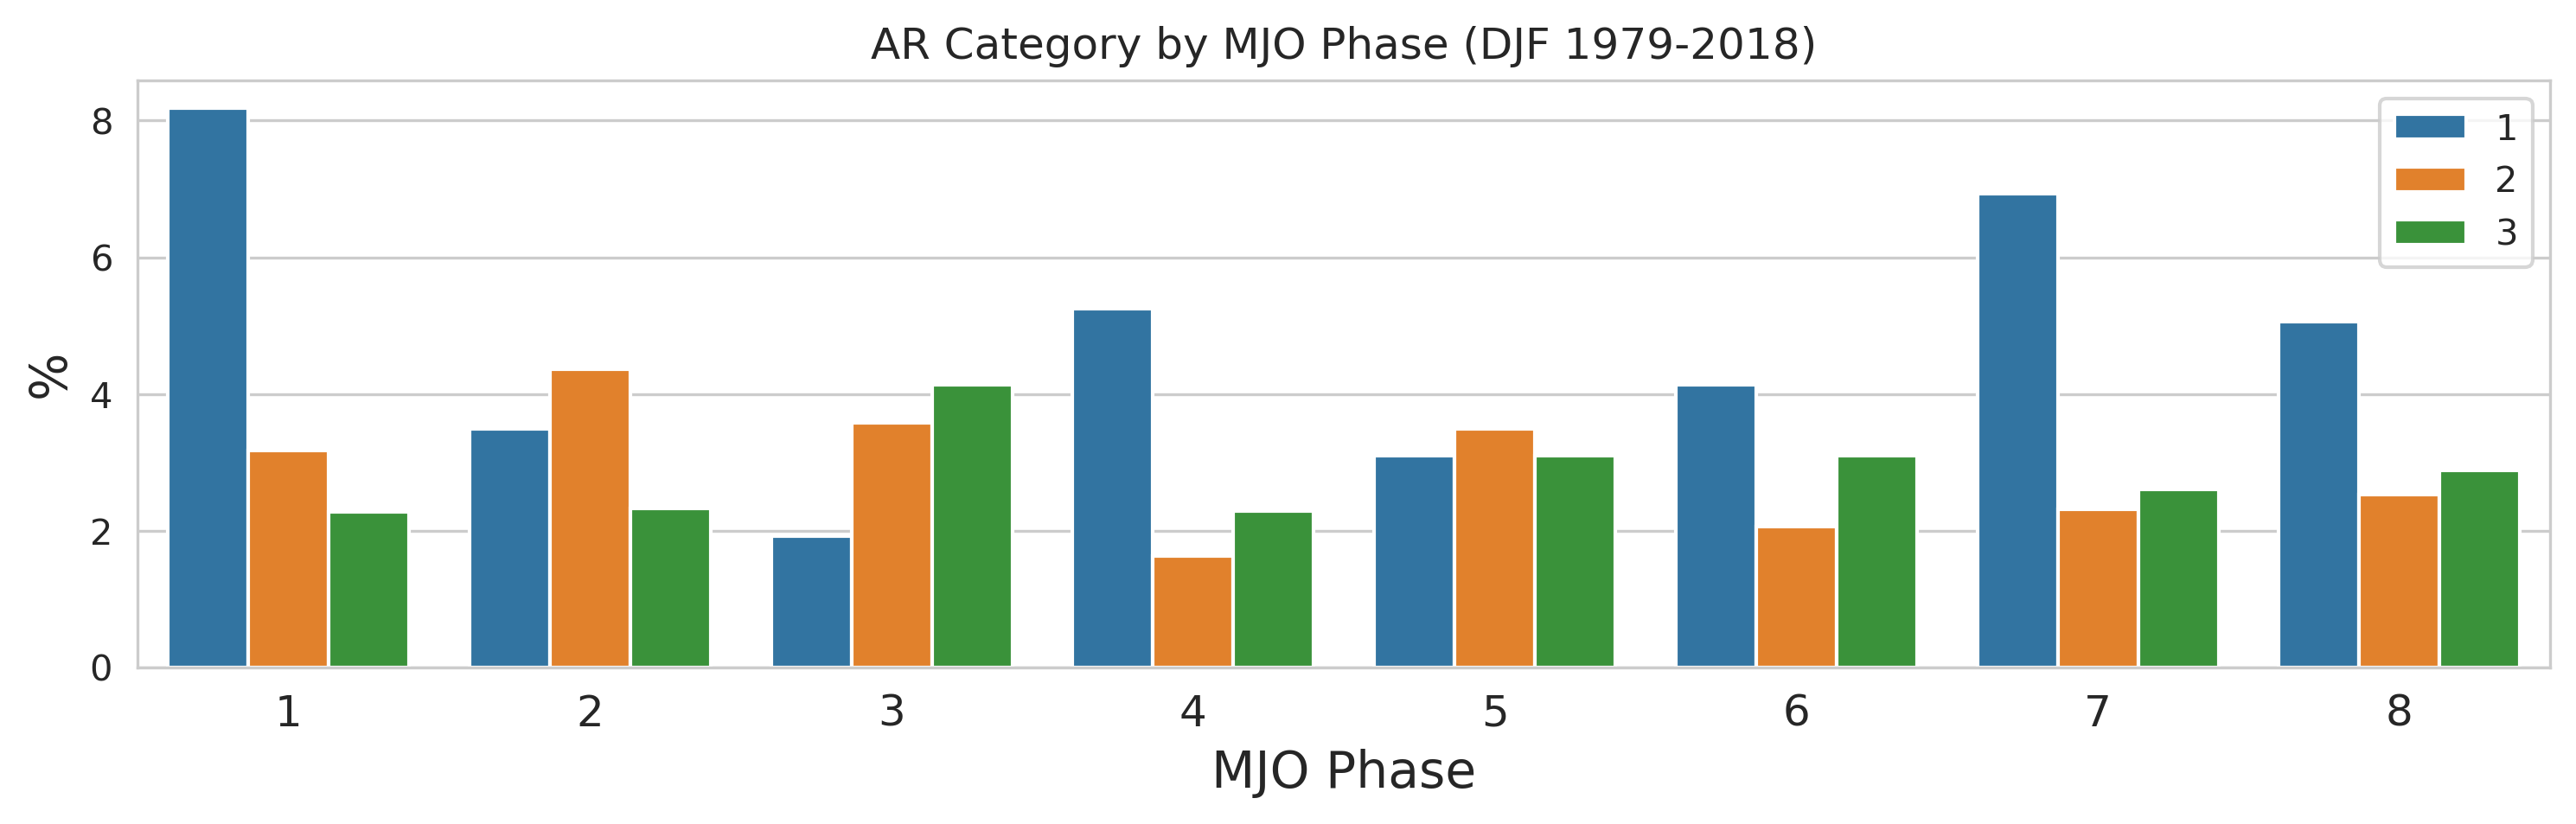

<Figure size 3600x900 with 0 Axes>

In [51]:
fname = path_to_figs + 'MJO_barplot_djf'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.0,3.0))
fig.dpi = 300
nplots=1

flatui = ["gold","lightcoral", "rebeccapurple"]
columns= np.arange(1, 9, 1)
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x='PHA', y='percFREQ', hue='ARCAT', data=dfObj)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title('AR Category by MJO Phase (DJF 1979-2018)', fontsize=12)
    ax.set_xlabel('MJO Phase', fontsize=14)
    ax.set_xticklabels(columns, fontsize=12)
    ax.legend(loc='upper right')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

/home/nash/DATA/repositories/AR_types/figs/ENSO_barplot_djf.png


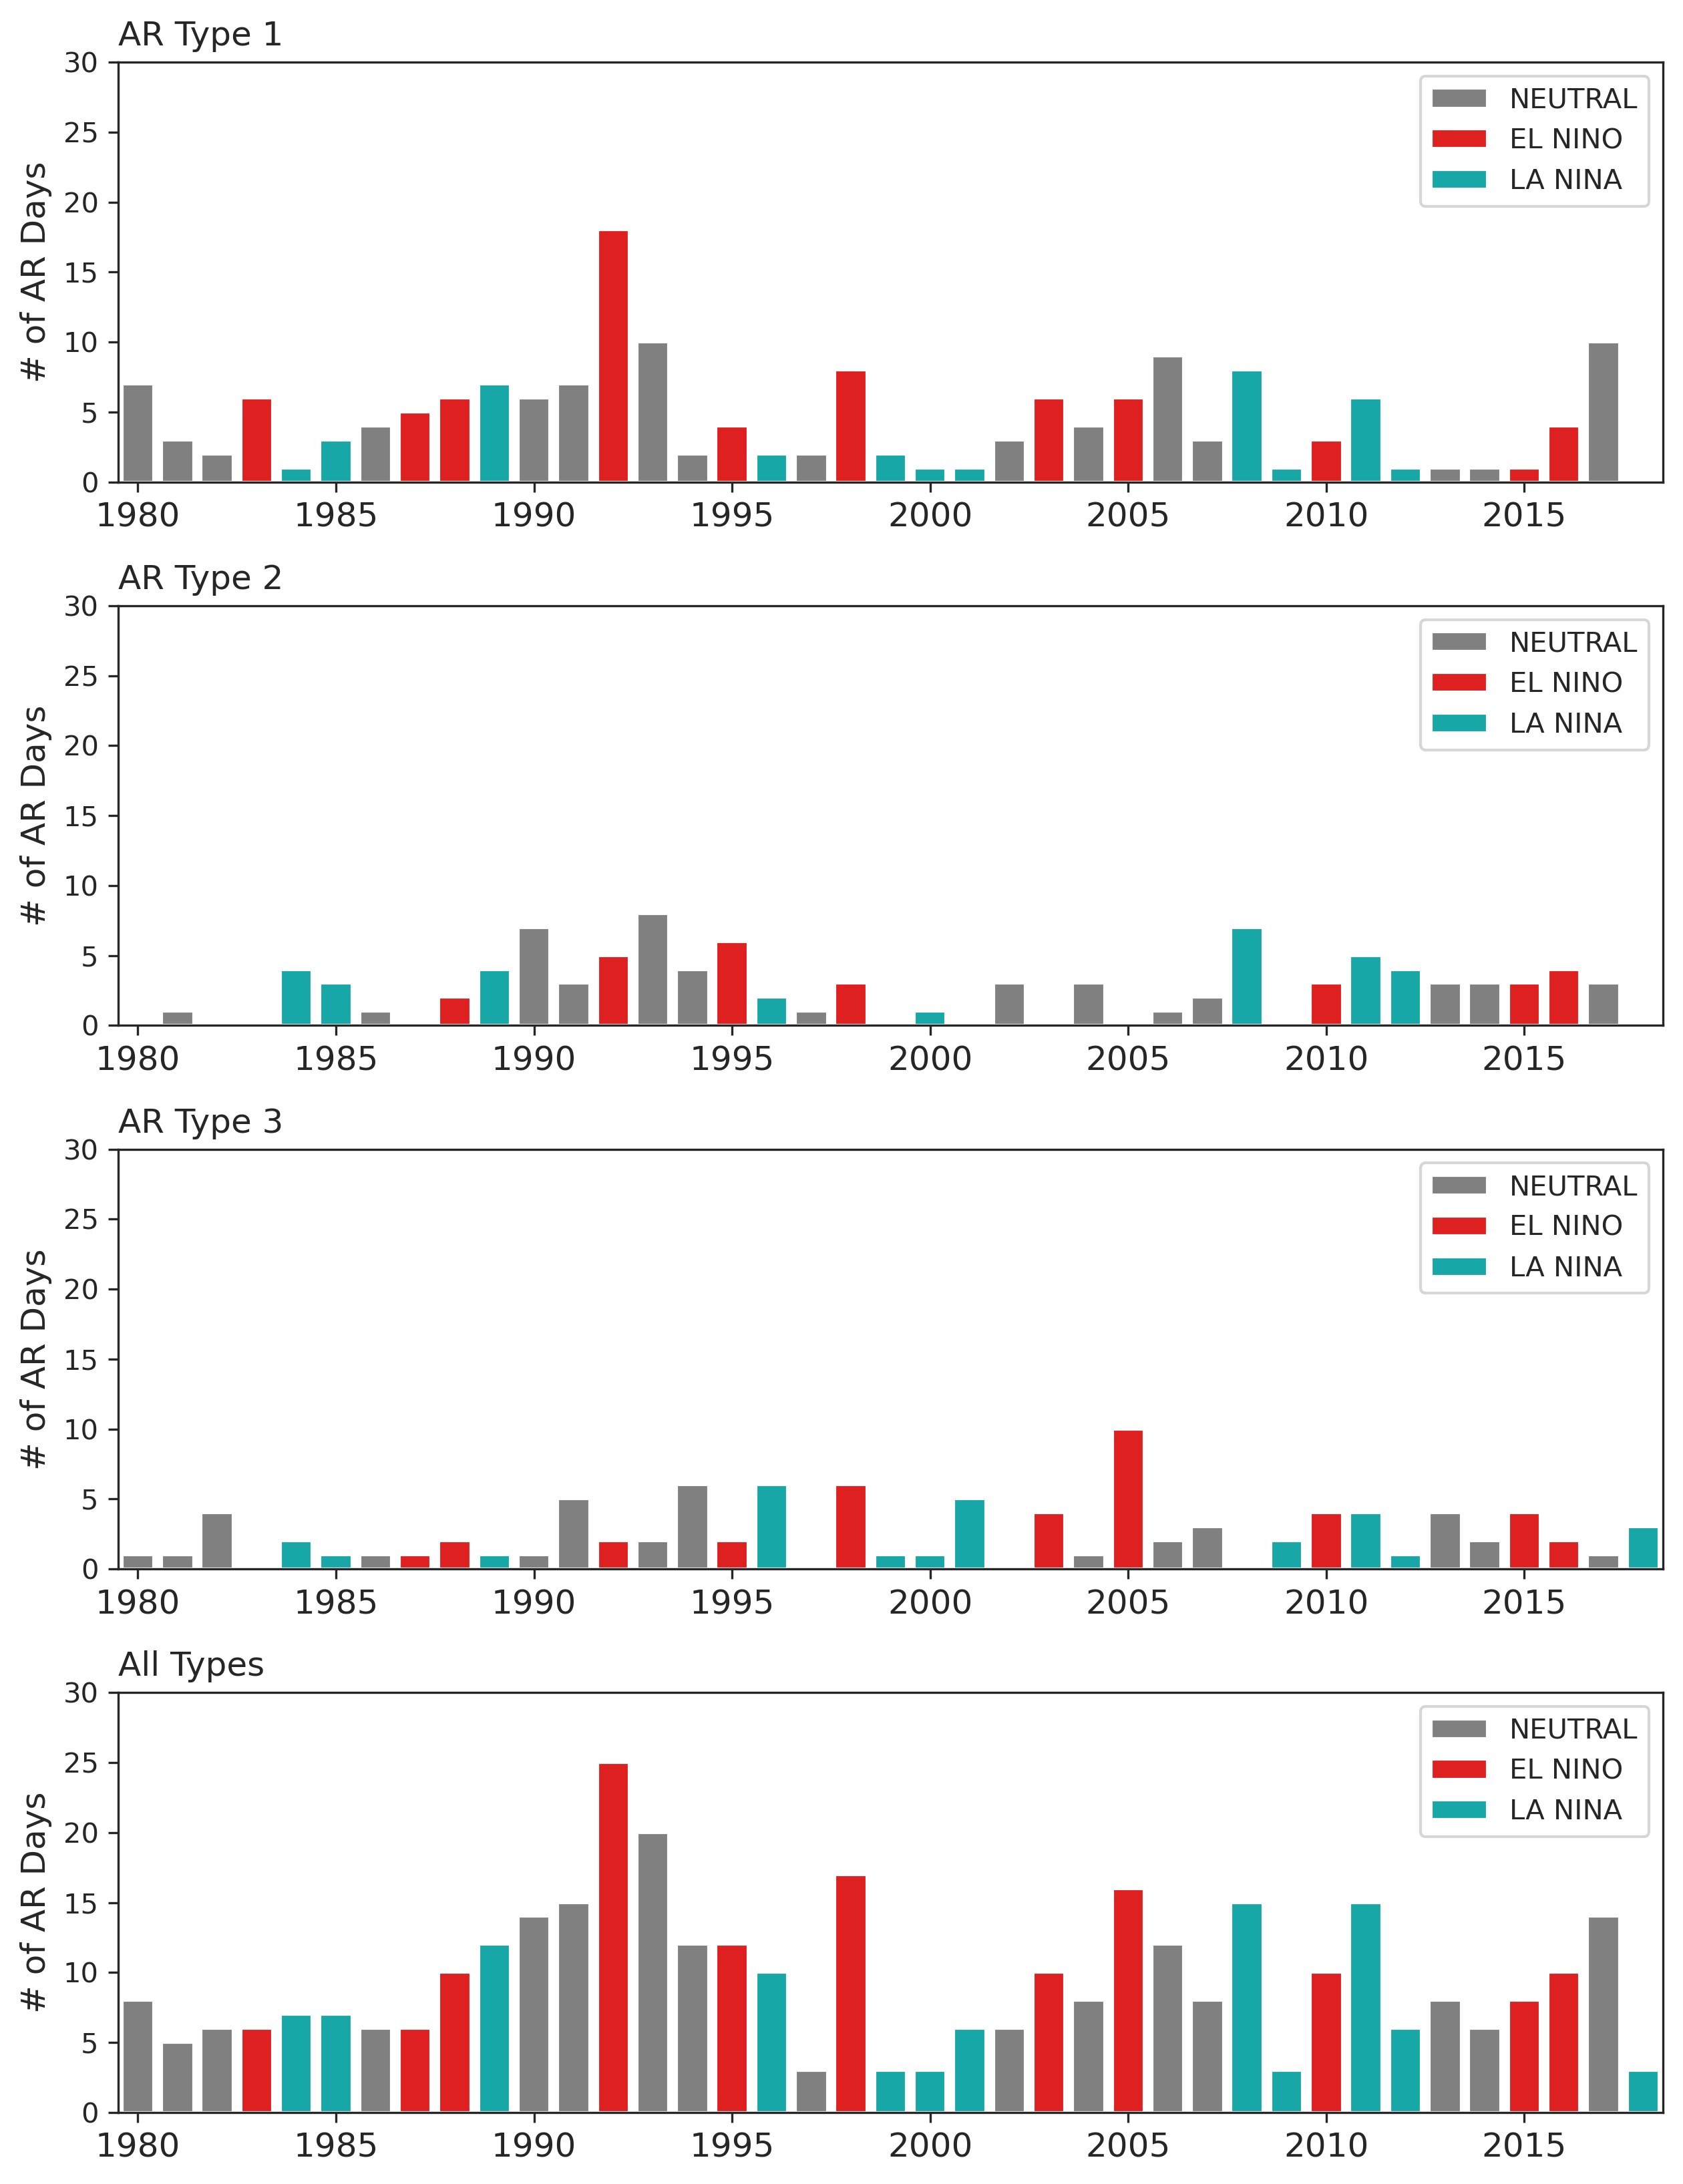

<Figure size 2550x3300 with 0 Axes>

In [11]:
fname = path_to_figs + 'ENSO_barplot_djf'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,11.0))
fig.dpi = 300
nplots=4

df = new_df
artype = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'total']
ssn_label = ['AR Type 1', 'AR Type 2', 'AR Type 3', 'All Types']
flatui = ['grey', 'red', 'c']

for i in np.arange(nplots):
    ax = fig.add_subplot(4, 1, i+1)
    data = new_df
    sns.barplot(x=data.index.year, y=df[artype[i]], hue='COND',
                data=data, palette=flatui, dodge=False)
    sns.set_style("ticks")
    ax.set_ylabel('# of AR Days', fontsize=12)
    ax.set_xlabel('')

    # Format the x axis
    ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
#     ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.set_xticklabels(np.arange(1975, 2020, 5), fontsize=12)
    ax.legend(loc='upper center')
    plt.gca().legend().set_title('')
    plt.ylim(0, 30)
    ax.set_title(ssn_label[i], loc='left')
    
plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [12]:
def _zstat_generic(value1, value2, std_diff, alternative, diff=0):
    '''generic (normal) z-test to save typing

    can be used as ztest based on summary statistics

    '''
    zstat = (value1 - value2 - diff) / std_diff
    if alternative in ['two-sided', '2-sided', '2s']:
        pvalue = stats.norm.sf(np.abs(zstat))*2
    elif alternative in ['larger', 'l']:
        pvalue = stats.norm.sf(zstat)
    elif alternative in ['smaller', 's']:
        pvalue = stats.norm.cdf(zstat)
    else:
        raise ValueError('invalid alternative')
    return zstat, pvalue

def ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled',
          ddof=1.):
    '''test for mean based on normal distribution, one or two samples

    In the case of two samples, the samples are assumed to be independent.

    Parameters
    ----------
    x1 : array_like, 1-D or 2-D
        first of the two independent samples
    x2 : array_like, 1-D or 2-D
        second of the two independent samples
    value : float
        In the one sample case, value is the mean of x1 under the Null
        hypothesis.
        In the two sample case, value is the difference between mean of x1 and
        mean of x2 under the Null hypothesis. The test statistic is
        `x1_mean - x2_mean - value`.
    alternative : string
        The alternative hypothesis, H1, has to be one of the following

           'two-sided': H1: difference in means not equal to value (default)
           'larger' :   H1: difference in means larger than value
           'smaller' :  H1: difference in means smaller than value

    usevar : string, 'pooled'
        Currently, only 'pooled' is implemented.
        If ``pooled``, then the standard deviation of the samples is assumed to be
        the same. see CompareMeans.ztest_ind for different options.
    ddof : int
        Degrees of freedom use in the calculation of the variance of the mean
        estimate. In the case of comparing means this is one, however it can
        be adjusted for testing other statistics (proportion, correlation)

    Returns
    -------
    tstat : float
        test statisic
    pvalue : float
        pvalue of the t-test

    Notes
    -----
    usevar not implemented, is always pooled in two sample case
    use CompareMeans instead.

    '''
    #usevar is not used, always pooled

    if usevar != 'pooled':
        raise NotImplementedError('only usevar="pooled" is implemented')

    x1 = np.asarray(x1)
    nobs1 = x1.shape[0]
    x1_mean = x1.mean(0)
    x1_var = x1.var(0)
    if x2 is not None:
        x2 = np.asarray(x2)
        nobs2 = x2.shape[0]
        x2_mean = x2.mean(0)
        x2_var = x2.var(0)
        var_pooled = (nobs1 * x1_var + nobs2 * x2_var)
        var_pooled /= (nobs1 + nobs2 - 2 * ddof)
        var_pooled *= (1. / nobs1 + 1. / nobs2)
    else:
        var_pooled = x1_var / (nobs1 - ddof)
        x2_mean = 0

    std_diff = np.sqrt(var_pooled)
    #stat = x1_mean - x2_mean - value
    return _zstat_generic(x1_mean, x2_mean, std_diff, alternative, diff=value)

def season_zstat(df, month):
    zstat_array = []
    pval_array = []
    
    s1 = df.loc[(df['month'] == month) & (df['COND'] == 'POSITIVE')]
    s2 = df.loc[(new_df['month'] == month) & (df['COND'] == 'NEGATIVE')]

    for i, subregion in enumerate(('AR_CAT1', 'AR_CAT2', 'AR_CAT3')):
        zstat, pval = ztest(s1[subregion].values, s2[subregion].values)
        
        zstat_array.append((zstat))
        pval_array.append((pval))

    return zstat_array, pval_array

def season_zstat(df, season):
    zstat_array = []
    pval_array = []
    zstat_array2 = []
    pval_array2 = []
    zstat_array3 = []
    pval_array3 = []
    
    s_nino = df.loc[(df['SEAS'] == season) & (df['COND'] == 'EL NINO')]
    s_nina = df.loc[(new_df['SEAS'] == season) & (df['COND'] == 'LA NINA')]
    s_neutral = df.loc[(new_df['SEAS'] == season) & (df['COND'] == 'NEUTRAL')]

    for i, subregion in enumerate(('AR_CAT1', 'AR_CAT2', 'AR_CAT3')):
        zstat, pval = ztest(s_nino[subregion].values, s_neutral[subregion].values)
        zstat2, pval2 = ztest(s_nina[subregion].values, s_neutral[subregion].values)
        zstat3, pval3 = ztest(s_nino[subregion].values, s_nina[subregion].values)
        
        zstat_array.append((zstat))
        pval_array.append((pval))
        
        zstat_array2.append(zstat2)
        pval_array2.append(pval2)
        
        zstat_array3.append(zstat3)
        pval_array3.append(pval3)
        
        zstat_final = zstat_array + zstat_array2 + zstat_array3
        pval_final = pval_array + pval_array2 + pval_array3
    return zstat_final, pval_final

In [13]:
DJF_z, DJF_p = season_zstat(new_df, 'DJF')
# MAM_z, MAM_p = season_zstat(new_df, 'MAM')
# JJA_z, JJA_p = season_zstat(new_df, 'JJA')
# SON_z, SON_p = season_zstat(new_df, 'SON')

In [15]:
arrays = [['El Nino - Neutral', 'El Nino - Neutral', 'El Nino - Neutral',
           'La Nina - Neutral','La Nina - Neutral','La Nina - Neutral',
          'El Nino - La Nina','El Nino - La Nina','El Nino - La Nina'],
           ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 
            'AR_CAT1', 'AR_CAT2', 'AR_CAT3', 
            'AR_CAT1', 'AR_CAT2', 'AR_CAT3']]
index = pd.MultiIndex.from_arrays(arrays, names=('% of AR Days', 'Subregion'))
df_z = pd.DataFrame({'DJF zstat': DJF_z,
                    'DJF pval': DJF_p},
                   index=index)
df_z

DJF zstat  DJF pval
% of AR Days      Subregion                     
El Nino - Neutral AR_CAT1     1.019897  0.307777
                  AR_CAT2    -0.374332  0.708157
                  AR_CAT3     1.418276  0.156110
La Nina - Neutral AR_CAT1    -1.665349  0.095843
                  AR_CAT2    -0.214335  0.830286
                  AR_CAT3     0.179978  0.857170
El Nino - La Nina AR_CAT1     2.227334  0.025925
                  AR_CAT2    -0.144356  0.885219
                  AR_CAT3     1.141074  0.253839